<a href="https://colab.research.google.com/github/rasecotineb/datascience/blob/master/time-series/ModeloSARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelo SARIMA

Se importa librerías a utilizar

In [1]:
import pandas as pd
import numpy as np
import random
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set()
plt.rcParams['figure.figsize'] = [10, 8]  #por defecto las figuras se displayan 8 pulgadas de ancho y 6 de alto

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm



Abajo se presenta un ejemplo de implementacion de modelo SARIMA para la serie <b>airline-passengers.csv</b>. 

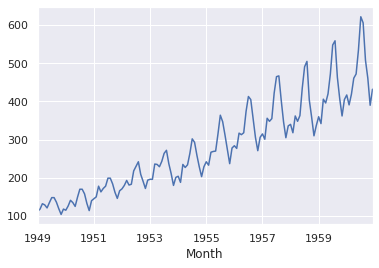

In [2]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# carga la serie  airline-passengers

series = pd.read_csv('https://drive.google.com/uc?id=15WdOVI0iBKP10tKea2nCBPKxXpng0CO6&export=download', header=0, index_col=0, parse_dates=True, squeeze=True)

# plotea la serie
series.plot()
plt.show()


En el plot se puede apreciar una tendencia positiva, estacionalidad, y varianza creciente. Antes de construir algún modelo trataremos de hacer estacionaria la varianza aplicando una transformacion logaritmica y luego  partimos la serie en 80% para entrenamiento y 20% para test.   

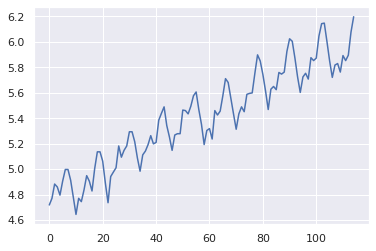

In [3]:
# saca logaritmo para tratar de hacer estacionaria la varianza de la serie
X = series.values
X = np.log(X)   

# Parte la serie en conjuntos de train/test
size = int(len(X) * 0.80)   # 80% para train,20% para test
train, test = X[0:size], X[size:len(X)]

# Plotea la serie transformada de train 
plt.plot(train)
plt.show()

En la gráfica anterior se puede observar que la varianza se estabiliza a lo largo del tiempo. Ahora diferenciamos para ver si se remueve la tendencia y se hace estacionaria

ADF Statistic: -2.635851
p-value: 0.085812
Critical Values:
	1%: -3.497
	5%: -2.891
	10%: -2.582


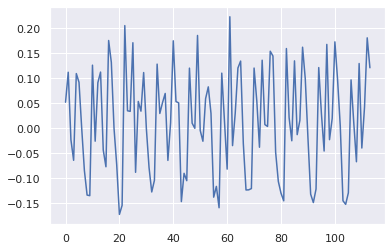

In [4]:
from statsmodels.tsa.stattools import adfuller

# create una serie de diferencias
def difference(dataset):
    diff = list()
    for i in range(1, len(dataset)):
        value = dataset[i] - dataset[i - 1]
        diff.append(value)
    return pd.Series(diff)

train_diff = difference(train)

# chequea si es estacionaria, para ello se evalúa la prueba estadística ADF
result = adfuller(train_diff)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

# plotea la serie diferenciada
train_diff.plot()
plt.show()

Se aprecia que la serie diferenciada es estacionaria a un nivel de significancia del 90% (valor mas relajado). Esto ocurre porque el patrón de estacionalidad aún está presente en la serie diferenciada. Veamos los plots de autocorrelacion (ACF) y autocorrelacion parcial (PACF) para tener una idea inicial de los paprametros del modelo  

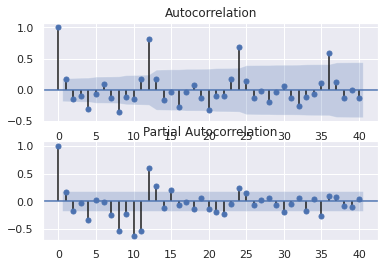

In [5]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

plt.figure()
plt.subplot(211)
plot_acf(train_diff, lags=40, ax=plt.gca())
plt.subplot(212)
plot_pacf(train_diff, lags=40, ax=plt.gca(), method='ols')
plt.show()

Podemos apreciar que el primer valor significante en PACF es en lag 1, mientras que el primer valor significante en el ACF se da en el Lag 4, lo que sugiere que p=1  y q=4. También se aprecia el componente estacional con un periodo S=12 en el ACF. Dado que el valor al lag S=12 en el ACF es positivo asumimos un valor P=1 y Q=0. Dado que el componente estacional es inestable con el tiempo asumimos un valor D=0. También asumiremos d=1, ya que estamos con una serie con tendencia aparentemente lineal.
Con ello, nuestro modelo Sarima seria:  SARIMA(1,1,4)(1,0,0)[12] . A continuación se muestra el código donde se hace el ajuste y la evaluacion de dicho modelo en Walk-forward. A modo de comparación se ajusta primero un modelo ARIMA(1,1,4).

In [6]:
# Grid search del modelo ARIMA para el dataset airline-passengers
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from numpy import sqrt
import warnings
warnings.filterwarnings("ignore")   # para evitar que muestre constantemente advertencias


# Evalua un modelo ARIMA en estrategia walk-forward (incorpora nuevos valores a la historia de uno en uno) para un orden dado (p,d,q) y fraccion de train
def evaluate_arima_model(X, arima_order, train_fraction):
    # prepare training dataset
    train_size = int(len(X) * train_fraction)
    train, test = X[0:train_size], X[train_size:]
    
    # hace las predicciones
    history = train.tolist()  # serie historica para ajustar el modelo. Inicialmente es train
    predictions = list()      # para almacenar las predicciones en test
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order) # crea el modelo ARIMA(p,d,q)
        model_fit = model.fit(disp=0)             # ajusta el modelo a los datos de history
        y_predicted = model_fit.forecast()[0]     # predice el siguiente punto despues de history
        predictions.append(y_predicted)
        history.append( test[t] ) 
    #   calculate el RMSE en test
    rmse = sqrt(mean_squared_error(test, predictions))    
    return rmse


# evalua de forma grid las mejores combinaciones de p_values, d_values, q_values de un modelo ARIMA
def grid_model_evaluation(series, train_fraction, p_values, d_values, q_values):
    series = series.astype('float32')  # asegura que la serie sea numerica
    best_score, best_cfg = float("inf"), None    #setea el valor máximo del error RMSE sobre el cual comparar
    # evaluacion grid
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
# Obtiene el RMSE de cada combinación de hiperparámetros                  
                    rmse = evaluate_arima_model(series, order, train_fraction)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('Modelo ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    print('Modelo ARIMA{} No se pudo ajustar'.format(order))
                    continue
    print('Mejor modelo: ARIMA%s, RMSE=%.3f' % (best_cfg, best_score))
    
# Valores de hiperparametros a evaluar
p_values = [0, 1, 2, 3, 4, 5, 6]
d_values =  [0, 1]
q_values =  [0, 1, 2, 3, 4, 5, 6]

train_fraction = 0.8

# realiza la evaluacion grid sobre el modelo ARIMA
grid_model_evaluation(X, train_fraction, p_values, d_values, q_values)

Modelo ARIMA(0, 0, 0) RMSE=0.620
Modelo ARIMA(0, 0, 1) RMSE=0.329
Modelo ARIMA(0, 0, 2) No se pudo ajustar
Modelo ARIMA(0, 0, 3) No se pudo ajustar
Modelo ARIMA(0, 0, 4) No se pudo ajustar
Modelo ARIMA(0, 0, 5) No se pudo ajustar
Modelo ARIMA(0, 0, 6) No se pudo ajustar
Modelo ARIMA(0, 1, 0) RMSE=0.117
Modelo ARIMA(0, 1, 1) RMSE=0.112
Modelo ARIMA(0, 1, 2) RMSE=0.127
Modelo ARIMA(0, 1, 3) RMSE=0.110
Modelo ARIMA(0, 1, 4) RMSE=0.096
Modelo ARIMA(0, 1, 5) No se pudo ajustar
Modelo ARIMA(0, 1, 6) RMSE=0.094
Modelo ARIMA(1, 0, 0) RMSE=0.115
Modelo ARIMA(1, 0, 1) RMSE=0.111
Modelo ARIMA(1, 0, 2) RMSE=0.183
Modelo ARIMA(1, 0, 3) RMSE=0.245
Modelo ARIMA(1, 0, 4) RMSE=0.158
Modelo ARIMA(1, 0, 5) RMSE=0.140
Modelo ARIMA(1, 0, 6) No se pudo ajustar
Modelo ARIMA(1, 1, 0) RMSE=0.113
Modelo ARIMA(1, 1, 1) RMSE=0.115
Modelo ARIMA(1, 1, 2) RMSE=0.104
Modelo ARIMA(1, 1, 3) RMSE=0.105
Modelo ARIMA(1, 1, 4) RMSE=0.097
Modelo ARIMA(1, 1, 5) RMSE=0.097
Modelo ARIMA(1, 1, 6) No se pudo ajustar
Modelo ARIMA

Ahora implementamos el modelo SARIMA(1,1,4)(1,0,0)[12] . Abajo se muestra el codigo donde se hace el ajuste y la evaluacion de dicho modelo en Walk-forward y se compara con un ARIMA(1,1,4)

RMSE walk-forward en test de modelo SARIMA: 17.701
RMSE walk-forward en test de modelo ARIMA: 43.738


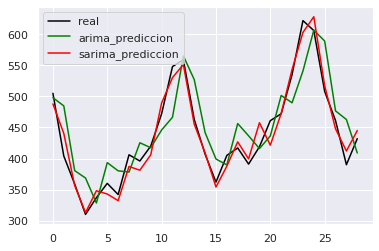

In [7]:
from sklearn.metrics import mean_squared_error   # para calcular el error cuadratico medio
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from math import sqrt

history = train.tolist()  # serie historica para ajustar el modelo. Inicialmente es train
predictions_sarima = list() # para almacenar las predicciones en test del modelo sarima
predictions_arima = list() # para almacenar las predicciones en test  del modelo arima

# evaluación walk-forward
for t in range(len(test)):
    
    # Ajusta modelo Sarima y realiza one-step forecast
    sarimamodel = SARIMAX(history, order=(1,1,4), seasonal_order=(1,0,0,12), enforce_stationarity=False, enforce_invertibility=False)
    sarimamodel_fit = sarimamodel.fit(disp=0)  # ajusta el modelo con los datos de history
    sarima_forecast = sarimamodel_fit.forecast()[0]  # predice el siguiente punto despues de history
    predictions_sarima.append(sarima_forecast)
    
    # Ajusta modelo Arima y realiza one-step forecast
    arimamodel = ARIMA(history, order=(1,1,4))  # instancia un modelo ARIMA(1,1,4)
    arimamodel_fit = arimamodel.fit(disp=0)  # ajusta el modelo con los datos de history
    arima_forecast = arimamodel_fit.forecast()[0]  # predice el siguiente punto despues de history
    predictions_arima.append(arima_forecast)
    
    history.append( test[t] )  # añade a history la observación actual de test 

# evalua el RMSE del modelo SARIMA
rmse = sqrt(mean_squared_error(np.exp(test), np.exp(predictions_sarima)))
print('RMSE walk-forward en test de modelo SARIMA: %.3f' % rmse)
    
# evalua el RMSE del modelo ARIMA
rmse = sqrt(mean_squared_error(np.exp(test), np.exp(predictions_arima)))
print('RMSE walk-forward en test de modelo ARIMA: %.3f' % rmse)

# plotea las predicciones versus lo real
plt.plot(np.exp(test), color='black')
plt.plot(np.exp(predictions_arima), color='green')
plt.plot(np.exp(predictions_sarima), color='red')
plt.legend(['real', 'arima_prediccion', 'sarima_prediccion'],  loc='upper left')
plt.show()

En el gráfico anterior  se puede observar que la curva SARIMA sigue con mejor ajuste a los datos reales que la curva ARIMA. Esto se refleja también por un menor RMSE de 17.701

## Optimización de hiperparámetros de un modelo SARIMA con Busqueda Grid

Una forma de encontrar hiperparámetros óptimos para un modelo Sarima es realizar búsqueda grid. Los parámetros que definen un modelo Sarima en Python son los siguientes:

    * order (p,d,q): parámetros para modelar el componente de tendencia 
    * seasonal_order (P, D, Q)[S]: parámetros para modelar el componente estacional
    * trend: Parámetro para especificar la tendencia determinística. Puede asumir los siguientes valores: 'n','c','t','ct', que indican respectivamente: "no tendencia", "constante", "lineal", y "constante con tendencia lineal" 

Para hacer búsqueda grid se crea primero una función **evaluate_sarima_model** que encapsule el proceso de evaluación del modelo, teniendo como entrada una serie temporal, la configuracion de hiperparametros SARIMA y la fraccion de la serie que será usada para train. Como salida se tiene el RMSE en walk-forward en la parte de test

In [8]:
# Evalua un modelo SARIMA en estrategia walk-forward para una configuracion de parámetros y fraccion de train
def evaluate_sarima_model(X, config, train_fraction):
    
    # desempaqueta los parámetros de la configuración dada 
    order, sorder, trend = config   
    
    # prepara train/test data
    train_size = int(len(X) * train_fraction)
    train, test = X[0:train_size], X[train_size:]
    
    # Intenta ajustar y predecir el Modelo SARIMA con la configuración dada. Si da error se atrapa en except
    try:
        # hace las predicciones
        history = train.tolist()  # Inicializa serie historica para ajustar el modelo con data de train
        predictions = list()      # para almacenar las predicciones en test
        for t in range(len(test)):
            # define el modelo SARIMA(p,d,q)(P,D,Q)[S]
            model = SARIMAX(history, order=order, seasonal_order=sorder, trend=trend, enforce_stationarity=False, enforce_invertibility=False) 
            model_fit = model.fit(disp=0)             # ajusta el modelo a los datos de history
            y_predicted = model_fit.forecast()[0]     # predice el siguiente punto despues de history
            predictions.append(y_predicted)
            history.append( test[t] ) 
            
        # calculate el RMSE en test
        rmse = sqrt(mean_squared_error(test, predictions))   
        print(' SARIMA[%s] %.3f' % (str(config), rmse))
    except:
        rmse = None

    return (str(config), rmse) 

La función sarima_configurations() de abajo sirve para crear una lista de configuraciones de modelos SARIMA a evaluar. Se  asume valores bajos o desactivados (0) de los parámetros. Es posible modificar estos rangos si se piensa que el orden puede ser mayor. Se puede especificar una lista de períodos estacionales (por defecto es 0 (no componente estacional)). A pesar de ser una cantidad elevada de posibles modelos, en la práctica, muchas no serán válidas y darán como resultado un error que se atrapa e ignora en <b>evaluate_sarima_model()</b>

In [9]:
# crea una lista de configuraciones de modelos Sarima para probar
def sarima_configurations(seasonal_periods=[0]):
    configs = list()
    # define config lists
    p_params = [0, 1, 2]
    d_params = [0, 1]
    q_params = [0, 1, 2]
    t_params = ['n','c','t','ct']
    P_params = [0, 1, 2]
    D_params = [0, 1]
    Q_params = [0, 1, 2]
    S_params = seasonal_periods
    # create config instances
    for p in p_params:
        for d in d_params:
            for q in q_params:
                for t in t_params:
                    for P in P_params:
                        for D in D_params:
                            for Q in Q_params:
                                for S in S_params:
                                    cfg = [(p,d,q), (P,D,Q,S), t]
                                    configs.append(cfg)
    return configs

Probemos en el dataset <b>airline-passengers.csv</b> 

In [ ]:
# carga la serie  airline-passengers
series = pd.read_csv('https://drive.google.com/uc?id=15WdOVI0iBKP10tKea2nCBPKxXpng0CO6&export=download', header=0, index_col=0, parse_dates=True, squeeze=True)

# saca logaritmo para tratar de hacer estacionaria la varianza de la serie
X = series.values
X = np.log(X)   
train_fraction = 0.8  # 80%  para entrenamiento

# obtiene la lista de configuraciones a probar 
config_list = sarima_configurations([0,12])

# hace la busqueda grid
scores = [ evaluate_sarima_model(X, config, train_fraction) for config in config_list ]

# remueve resultados vacios
scores = [r for r in scores if r[1] != None]

# ordena los resultados de mmenor a mayor rmse
scores.sort(key=lambda tup: tup[1])

# Imprime las top 3 configuraciones
for config, rmse in scores[:3]:
    print(config, rmse)

 SARIMA[[(0, 0, 0), (0, 0, 0, 0), 'n']] 6.075
 SARIMA[[(0, 0, 0), (0, 0, 0, 12), 'n']] 6.075
 SARIMA[[(0, 0, 0), (0, 0, 1, 0), 'n']] 3.055
 SARIMA[[(0, 0, 0), (0, 0, 1, 12), 'n']] 3.227
 SARIMA[[(0, 0, 0), (0, 0, 2, 0), 'n']] 1.601
 SARIMA[[(0, 0, 0), (0, 0, 2, 12), 'n']] 2.614
 SARIMA[[(0, 0, 0), (0, 1, 0, 12), 'n']] 0.108
 SARIMA[[(0, 0, 0), (0, 1, 1, 12), 'n']] 0.095
 SARIMA[[(0, 0, 0), (0, 1, 2, 12), 'n']] 0.089
 SARIMA[[(0, 0, 0), (1, 0, 0, 0), 'n']] 0.117
 SARIMA[[(0, 0, 0), (1, 0, 0, 12), 'n']] 0.060
 SARIMA[[(0, 0, 0), (1, 0, 1, 0), 'n']] 0.112
 SARIMA[[(0, 0, 0), (1, 0, 1, 12), 'n']] 0.069
 SARIMA[[(0, 0, 0), (1, 0, 2, 0), 'n']] 0.122
 SARIMA[[(0, 0, 0), (1, 0, 2, 12), 'n']] 0.074
 SARIMA[[(0, 0, 0), (1, 1, 0, 12), 'n']] 0.083
 SARIMA[[(0, 0, 0), (1, 1, 1, 12), 'n']] 0.052
 SARIMA[[(0, 0, 0), (1, 1, 2, 12), 'n']] 0.035
 SARIMA[[(0, 0, 0), (2, 0, 0, 0), 'n']] 0.113
 SARIMA[[(0, 0, 0), (2, 0, 0, 12), 'n']] 0.065
 SARIMA[[(0, 0, 0), (2, 0, 1, 0), 'n']] 0.111
 SARIMA[[(0, 0, 0), (